# Objetivo general del código

Transformar el formato de BRAT .ann a un formato interpretable por la red neuronal. Hay dos opciones:

1. Considerar cada nota clínica como una entrada al algoritmo. Como ventaja habrá más contexto. Como desventaja, el tamaño de la nota superará en muchas ocasiones los 512 tokens y habrá que truncarla de forma arbitraria

2. Considerar cada frase dentro de cada nota clínica como una entrada al algoritmo. Como desventaja, el entrenamiento tardará más (mayor cantidad de información). Como ventaja se puede tener en cuenta toda la información de la nota clínica (sin embargo los fragmentos no están relacionados unos con otros)

Codigo para transformar el corpus de entrada, anotado en formato BRAT Standoff, en formato IOB.

Para ello debemos tener almacenar tanto las notas .ann como las .txt en el mismo directorio.

Este código se ejecuta directamente sobre el corpus MEDDOPROF descargado de la convocatoria o sobre el código del corpus MOD una vez se ha procesado con el script `ProcesadoMOD.ipynb`

Para hacer funcionar el script debemos usar el tokenizador de Spacy. 

Hay tres versiones posibles en español:

1. !python -m spacy download es_core_news_sm (sm: no word vectors)
2. !python -m spacy download es_core_news_md (md: reduced word vector table with 20k unique vectors for ~500k words)
3. !python -m spacy download es_core_news_md (lg: large word vector table with ~500k entries)

En función de la versión sm, md o lg, cambia el tamaño del modelo. Esto se puede ver [en el siguiente enlace](https://stackoverflow.com/questions/50487495/what-is-difference-between-en-core-web-sm-en-core-web-mdand-en-core-web-lg-mod)

`Core` indica:  a general-purpose model with tagging, parsing, lemmatization and named entity recognition

Debemos tener en cuenta que si usamos corpus en inglés tenemos que usar un tokenizador en inglés

Establecemos conexión con Google Drive

In [1]:
from google.colab import drive
#Enlazamos nuestro notebook en Colab con nuestro almacenamiento en Google Drive 
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos spaCy

In [2]:
# install the requirements
!pip install spacy

# Instalamos los modelos

# Español
!python -m spacy download es_core_news_sm # El que recomienda spacy por defecto
#!python -m spacy download es_core_news_md # El primero usado por mi
#!python -m spacy download es_core_news_lg #

# Inglés
#!python -m spacy download en_core_web_md
#!python -m spacy download en_core_news_md
#!python -m spacy download es_core_web_md

# Concatenar ann data. No nos sirve, finalmente no hacemos uso de esta librería
#!pip install anndata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-20 07:13:04.141301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 07:13:04.986688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 102.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


## Obtención del formato BIO
Usamos el código de NeuroNER extraído de

https://github.com/Franck-Dernoncourt/NeuroNER

Este código lo lanzamos sobre los archivos que se han procesado y guardado previamente en `/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/Task1/modificado`

Estos archivos los movemos posteriormente a `/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/Task1/`, sustituyendo todo lo que ahí había

In [3]:
!pip install pycorenlp
!pip3 install pyneuroner[cpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pycorenlp: filename=pycorenlp-0.3.0-py3-none-any.whl size=2142 sha256=0a02f84a9a8c6f0a63b8f933f5e01054df353e301be8c6bca4dabe1951e37033
  Stored in directory: /root/.cache/pip/wheels/99/43/83/53a89b5afcfe4bdaeec4ef0ff54ab0e09d6d3683d2884d1b4d
Successfully built pycorenlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 79.7 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
import codecs
import glob
import json
import os

from pycorenlp import StanfordCoreNLP
import spacy

from neuroner import utils_nlp

def get_start_and_end_offset_of_token_from_spacy(token):
    start = token.idx
    end = start + len(token)
    return start, end

def get_sentences_and_tokens_from_spacy(text, spacy_nlp):
    document = spacy_nlp(text)
    # sentences
    sentences = []
    for span in document.sents:
        sentence = [document[i] for i in range(span.start, span.end)]
        sentence_tokens = []
        for token in sentence:
            token_dict = {}
            token_dict['start'], token_dict['end'] = get_start_and_end_offset_of_token_from_spacy(token)
            token_dict['text'] = text[token_dict['start']:token_dict['end']]
            if token_dict['text'].strip() in ['\n', '\t', ' ', '']:
                continue
            # Make sure that the token text does not contain any space
            if len(token_dict['text'].split(' ')) != 1:
                print("WARNING: the text of the token contains space character, replaced with hyphen\n\t{0}\n\t{1}".format(token_dict['text'], 
                                                                                                                           token_dict['text'].replace(' ', '-')))
                token_dict['text'] = token_dict['text'].replace(' ', '-')
            sentence_tokens.append(token_dict)
        sentences.append(sentence_tokens)
    return sentences

def get_stanford_annotations(text, core_nlp, port=9000, annotators='tokenize,ssplit,pos,lemma'):
    output = core_nlp.annotate(text, properties={
        "timeout": "10000",
        "ssplit.newlineIsSentenceBreak": "two",
        'annotators': annotators,
        'outputFormat': 'json'
    })
    if type(output) is str:
        output = json.loads(output, strict=False)
    return output

def get_sentences_and_tokens_from_stanford(text, core_nlp):
    stanford_output = get_stanford_annotations(text, core_nlp)
    sentences = []
    for sentence in stanford_output['sentences']:
        tokens = []
        for token in sentence['tokens']:
            token['start'] = int(token['characterOffsetBegin'])
            token['end'] = int(token['characterOffsetEnd'])
            token['text'] = text[token['start']:token['end']]
            if token['text'].strip() in ['\n', '\t', ' ', '']:
                continue
            # Make sure that the token text does not contain any space
            if len(token['text'].split(' ')) != 1:
                print("WARNING: the text of the token contains space character, replaced with hyphen\n\t{0}\n\t{1}".format(token['text'], 
                                                                                                                           token['text'].replace(' ', '-')))
                token['text'] = token['text'].replace(' ', '-')
            tokens.append(token)
        sentences.append(tokens)
    return sentences

def get_entities_from_brat(text_filepath, annotation_filepath, verbose=False):
    # load text
    with codecs.open(text_filepath, 'r', 'UTF-8') as f:
        text =f.read()
    if verbose: print("\ntext:\n{0}\n".format(text))

    # parse annotation file
    entities = []
    with codecs.open(annotation_filepath, 'r', 'UTF-8') as f:
        for line in f.read().splitlines():
            anno = line.split()
            id_anno = anno[0]
            # parse entity
            if id_anno[0] == 'T':
                entity = {}
                entity['id'] = id_anno
                entity['type'] = anno[1]
                entity['start'] = int(anno[2])
                entity['end'] = int(anno[3])
                entity['text'] = ' '.join(anno[4:])
                if verbose:
                    print("entity: {0}".format(entity))
                # Check compatibility between brat text and anootation
                if utils_nlp.replace_unicode_whitespaces_with_ascii_whitespace(text[entity['start']:entity['end']]) != \
                    utils_nlp.replace_unicode_whitespaces_with_ascii_whitespace(entity['text']):
                    print("Warning: brat text and annotation do not match.")
                    print("\ttext: {0}".format(text[entity['start']:entity['end']]))
                    print("\tanno: {0}".format(entity['text']))
                # add to entitys data
                entities.append(entity)
    if verbose: print("\n\n")
    
    return text, entities

def check_brat_annotation_and_text_compatibility(brat_folder):
    '''
    Check if brat annotation and text files are compatible.
    '''
    dataset_type =  os.path.basename(brat_folder)
    print("Checking the validity of BRAT-formatted {0} set... ".format(dataset_type), end='')
    text_filepaths = sorted(glob.glob(os.path.join(brat_folder, '*.txt')))
    for text_filepath in text_filepaths:
        base_filename = os.path.splitext(os.path.basename(text_filepath))[0]
        annotation_filepath = os.path.join(os.path.dirname(text_filepath), base_filename + '.ann')
        # check if annotation file exists
        if not os.path.exists(annotation_filepath):
            raise IOError("Annotation file does not exist: {0}".format(annotation_filepath))
        text, entities = get_entities_from_brat(text_filepath, annotation_filepath)
    print("Done.")

def brat_to_conll(input_folder, output_filepath, tokenizer, language):
    '''
    Assumes '.txt' and '.ann' files are in the input_folder.
    Checks for the compatibility between .txt and .ann at the same time.
    '''
    if tokenizer == 'spacy':
        spacy_nlp = spacy.load(language)
    elif tokenizer == 'stanford':
        core_nlp = StanfordCoreNLP('http://localhost:{0}'.format(9000))
    else:
        raise ValueError("tokenizer should be either 'spacy' or 'stanford'.")
    verbose = False
    dataset_type =  os.path.basename(input_folder)
    print("Formatting {0} set from BRAT to CONLL... ".format(dataset_type), end='')
    text_filepaths = sorted(glob.glob(os.path.join(input_folder, '*.txt')))
    output_file = codecs.open(output_filepath, 'w', 'utf-8')
    for text_filepath in text_filepaths:
        base_filename = os.path.splitext(os.path.basename(text_filepath))[0]
        annotation_filepath = os.path.join(os.path.dirname(text_filepath), base_filename + '.ann')
        # create annotation file if it does not exist
        if not os.path.exists(annotation_filepath):
            codecs.open(annotation_filepath, 'w', 'UTF-8').close()

        text, entities = get_entities_from_brat(text_filepath, annotation_filepath)
        entities = sorted(entities, key=lambda entity:entity["start"])
        
        if tokenizer == 'spacy':
            sentences = get_sentences_and_tokens_from_spacy(text, spacy_nlp)
        elif tokenizer == 'stanford':
            sentences = get_sentences_and_tokens_from_stanford(text, core_nlp)
        
        for sentence in sentences:
            inside = False
            previous_token_label = 'O'
            for token in sentence:
                token['label'] = 'O'
                for entity in entities:
                    if entity['start'] <= token['start'] < entity['end'] or \
                       entity['start'] < token['end'] <= entity['end'] or \
                       token['start'] < entity['start'] < entity['end'] < token['end']:

                        token['label'] = entity['type'].replace('-', '_') # Because the ANN doesn't support tag with '-' in it

                        break
                    elif token['end'] < entity['start']:
                        break
                        
                if len(entities) == 0:
                    entity={'end':0}
                if token['label'] == 'O':
                    gold_label = 'O'
                    inside = False
                elif inside and token['label'] == previous_token_label:
                    gold_label = 'I-{0}'.format(token['label'])
                else:
                    inside = True
                    gold_label = 'B-{0}'.format(token['label'])
                if token['end'] == entity['end']:
                    inside = False
                previous_token_label = token['label']
                if verbose: print('{0} {1} {2} {3} {4}\n'.format(token['text'], base_filename, token['start'], token['end'], gold_label))
                output_file.write('{0} {1} {2} {3} {4}\n'.format(token['text'], base_filename, token['start'], token['end'], gold_label))
            if verbose: print('\n')
            output_file.write('\n')

    output_file.close()
    print('Done.')
    if tokenizer == 'spacy':
        del spacy_nlp
    elif tokenizer == 'stanford':
        del core_nlp

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Las anotaciones se convierten en un único archivo

In [ ]:
# Poner el tokenizador en espanol

# MEDDOPROF
# El formato que vamos a usar es sm

# sm
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task1", "task1neuronersm.txt", "spacy", "es_core_news_sm")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task2", "task2neuronersm.txt", "spacy", "es_core_news_sm")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/class", "classneuronersm.txt", "spacy", "es_core_news_sm")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/ner", "nerneuronersm.txt", "spacy", "es_core_news_sm")

# md
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task1", "task1neuroner.txt", "spacy", "es_core_news_md")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task2", "task2neuroner.txt", "spacy", "es_core_news_md")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/class", "classneuroner.txt", "spacy", "es_core_news_md")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/ner", "nerneuroner.txt", "spacy", "es_core_news_md")
# lg
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task1", "task1neuronersm.txt", "spacy", "es_core_news_lg")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Train/task2", "task2neuronersm.txt", "spacy", "es_core_news_lg")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/class", "classneuronersm.txt", "spacy", "es_core_news_lg")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/Original/Test/ner", "nerneuronersm.txt", "spacy", "es_core_news_lg")

Formatting Task1 set from BRAT to CONLL... Done.
Formatting Task2 set from BRAT to CONLL... Done.


In [ ]:
# MOD CORPUS
# Debemos asegurarnos una ejecución limpia, es decir, que en task no se haya ejecutado esto previamente y que el archivo taskXMODneuronersm no esté creado
# Formato sm
brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Task1", "/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task1MODneuronersm.txt", "spacy", "es_core_news_sm")
#brat_to_conll("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Task2", "/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task2MODneuronersm.txt", "spacy", "es_core_news_sm")

Formatting Task1 set from BRAT to CONLL... Done.
Formatting Task2 set from BRAT to CONLL... Done.


El resultado que obtenemos después de ejecutar todo lo anterior es un archivo de texo que tiene en la primera posición un token, en la segunda, el identificador de la nota, en la tercera la posición de comienzo del token, en la cuarta la posición de fin del token y en la quinta la etiqueta.

Cada frase está separada por una línea en blanco.

En resumen: El resultado obtenido es un único archivo .BIO con todas las sentencias de todas las notas, separadas por una línea en blanco (empty line).

## Identificación de cada frase

Este código inicialmente fue desarrollado en un cuaderno de Jupyter llamado `Separar frases`

El código mostrado a continuación busca añadir el identificador de sentencia

Para ello, vamos a añadir la información de número de sentencia directamente mediante bucle


In [ ]:
from google.colab import drive
#Enlazamos nuestro notebook en Colab con nuestro almacenamiento en Google Drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Cargamos las librerias necesarias
import pandas as pd

# Cargamos los datos. Dado que el archivo obtenido de BIO tiene nueva línea vacía como delimitador de cada frase usamos el parámetro
# skip_blank_lines = False

# Cargamos los distintos conjuntos de datos procedentes del script NEURONER (Paso anterior)
# Comentamos y descomentamos cada línea para hacer el procesamiento y la visualización

# MEDDOPROF
datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task1neuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)
#datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task2neuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)
#datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/nerneuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)
#datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/classneuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)

# MOD
#datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task1MODneuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)
#datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task2MODneuronersm.txt", sep=' ', names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip', skip_blank_lines=False)

Cargamos dos veces el conjunto de datos, una vez teniendo en cuenta las líneas nuevas en blanco que separan las frases y otra sin tenerlo en cuenta, para ver si al final de nuestro procesamiento hay discrepancias.

In [25]:
# Vemos originalmente qué longitud de tokens tiene el archivo de NeuroNER eliminando las líneas en blanco

#len(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task1neuronersm.txt", sep=' ', 
#                    names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip'))

#len(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task2neuronersm.txt", sep=' ', 
#                    names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip'))

#len(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/nerneuronersm.txt", sep=' ', 
#                    names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip'))

#len(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/classneuronersm.txt", sep=' ', 
#                    names=['words', 'fileId', 'start', 'end', 'label'], quoting=3, on_bad_lines='skip'))

In [5]:
datos[0:5]

,words,fileId,start,end,label
0,Un,32247016_ES,0.0,2.0,O
1,paciente,32247016_ES,3.0,11.0,O
2,de,32247016_ES,12.0,14.0,O
3,unos,32247016_ES,15.0,19.0,O
4,cincuenta,32247016_ES,20.0,29.0,O


Añadimos un identificador de cada sentencia mediante un bucle

Hemos observados que hay dos líneas consecutivas con espacios en blanco.
Esto puede introducir ruido, dado que los identificadores de sentencia pueden no ser consecutivos por ejemplo pueden saltar del 31 al 33. Sin embargo, dado que son únicos, no nos preocupa. Por ejemplo:

In [6]:
datos[900:910]

,words,fileId,start,end,label
900,aspiración,32399950_ES,2751.0,2761.0,O
901,),32399950_ES,2761.0,2762.0,O
902,.,32399950_ES,2762.0,2763.0,O
903,NaN,NaN,NaN,NaN,NaN
904,NaN,NaN,NaN,NaN,NaN
905,﻿El,32417987_ES,0.0,3.0,O
906,28,32417987_ES,4.0,6.0,O
907,de,32417987_ES,7.0,9.0,O
908,febrero,32417987_ES,10.0,17.0,O
909,de,32417987_ES,18.0,20.0,O


Procesado MEDDOPROF

In [26]:
# Creamos lista y contador
lista = []

# Las notas de MEDDOPROF empiezan a numerarse desde el 1.
# Las notas de MOD deben seguir una numeración para que no haya un mismo identificador de sentencia
# en los dos corpus

contador = 1

for i in range(len(datos)):
    # Si la línea actual no es separador de sentencia añadimos el número de la sentencia
    if ((pd.isna(datos.words[i]) == False) | (pd.isna(datos.label[i]) == False)):
        lista.append(contador)
    # Si la línea actual es separador de sentencia, añadimos un 0 y aumentamos a 1 el contador para que la siguiente sentencia a la actual tenga otro identificador
    if ((pd.isna(datos.words[i]) == True) & (pd.isna(datos.label[i]) == True)):
        lista.append(0)
        contador = contador +1 
        
# Adjuntamos la lista creada como columna del df        
datos['sentenceID'] = lista

# Vemos el aspecto de los datos
datos

,words,fileId,start,end,label,sentenceID
0,Un,32247016_ES,0.0,2.0,O,1
1,paciente,32247016_ES,3.0,11.0,O,1
2,de,32247016_ES,12.0,14.0,O,1
3,unos,32247016_ES,15.0,19.0,O,1
4,cincuenta,32247016_ES,20.0,29.0,O,1
...,...,...,...,...,...,...
1129609,tratado,cc_otorrinolaringologia96,783.0,790.0,O,53124
1129610,con,cc_otorrinolaringologia96,791.0,794.0,O,53124
1129611,inmunoterapia,cc_otorrinolaringologia96,795.0,808.0,O,53124
1129612,.,cc_otorrinolaringologia96,808.0,809.0,O,53124


Procesado MOD

In [ ]:
# Creamos lista y contador
lista = []

# Las notas de MEDDOPROF empiezan a numerarse desde el 1.
# Las notas de MOD deben seguir una numeración para que no haya un mismo identificador de sentencia
# en los dos corpus

contador = 2000000 # para dar más margen empezamos a contar a partir de 2 millones
#contador = 1129613 # empezamos a contar a partir del último número de MEDDOPROF

for i in range(len(datos)):
    # Si la línea actual no es separador de sentencia añadimos el número de la sentencia
    if ((pd.isna(datos.words[i]) == False) | (pd.isna(datos.label[i]) == False)):
        lista.append(contador)
    # Si la línea actual es separador de sentencia, añadimos un 0 y aumentamos a 1 el contador para que la siguiente sentencia a la actual tenga otro identificador
    if ((pd.isna(datos.words[i]) == True) & (pd.isna(datos.label[i]) == True)):
        lista.append(0)
        contador = contador +1 
        
# Adjuntamos la lista creada como columna del df        
datos['sentenceID'] = lista

# Vemos el aspecto de los datos
datos

,words,fileId,start,end,label,sentenceID
0,El,32085846_ES,0.0,3.0,O,2000000
1,21,32085846_ES,4.0,6.0,O,2000000
2,de,32085846_ES,7.0,9.0,O,2000000
3,enero,32085846_ES,10.0,15.0,O,2000000
4,de,32085846_ES,16.0,18.0,O,2000000
...,...,...,...,...,...,...
234395,insight,es-S0211-57352013000300011-1,4544.0,4551.0,O,2010507
234396,parcial,es-S0211-57352013000300011-1,4552.0,4559.0,O,2010507
234397,.,es-S0211-57352013000300011-1,4559.0,4560.0,O,2010507
234398,NaN,NaN,NaN,NaN,NaN,0


Código común, independientemente de MEDDOPROF o MOD

---



In [27]:
# Ahora eliminamos las filas que tengan un identificador de sentenceID == 0 (es decir que separe sentencias entre si)
datos = datos.loc[datos["sentenceID"] > 0]
datos[0:50]

,words,fileId,start,end,label,sentenceID
0,Un,32247016_ES,0.0,2.0,O,1
1,paciente,32247016_ES,3.0,11.0,O,1
2,de,32247016_ES,12.0,14.0,O,1
3,unos,32247016_ES,15.0,19.0,O,1
4,cincuenta,32247016_ES,20.0,29.0,O,1
5,años,32247016_ES,30.0,34.0,O,1
6,sin,32247016_ES,35.0,38.0,O,1
7,antecedentes,32247016_ES,39.0,51.0,O,1
8,personales,32247016_ES,52.0,62.0,O,1
9,acudió,32247016_ES,63.0,69.0,O,1


In [28]:
# Vemos si hay algún valor a NaN
datos['words'].isna().sum()

6

In [29]:
# Eliminamos la fila con NaN
datos = datos.dropna(subset=['words'])
len(datos)

1076484

In [30]:
# Vemos la longitud de la sentencia más larga
datos.sentenceID.value_counts().max()

373

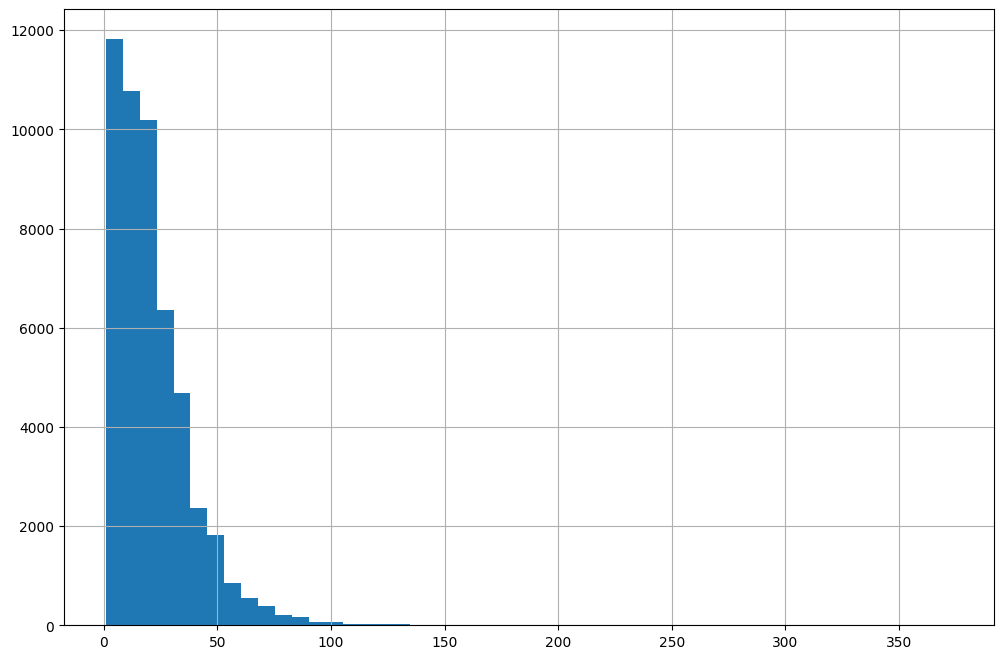

In [31]:
# Vemos un histograma para hacernos una idea de la longitud promedio de las sentencias
# Debemos tener en cuenta que esto es número medio de tokens, sin embargo, BERT usa el nivel de subtoken, por lo que será mucho más grande
import matplotlib.pyplot as plt
datos.sentenceID.value_counts().hist(bins=50, figsize=(12, 8))
plt.show()

In [32]:
# Vemos las métricas de las frases
datos.sentenceID.value_counts().describe(include='all')

count    50442.000000
mean        21.341025
std         17.298319
min          1.000000
25%          9.000000
50%         17.000000
75%         29.000000
max        373.000000
Name: sentenceID, dtype: float64

In [33]:
# Vamos a ver cuantas sentencias tienen una longitud superior a 100
# Código extraido de: https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe

value_counts = datos['sentenceID'].value_counts(dropna=True, sort=True)

# Transformamos el output del value_counts a un df
df_val_counts = pd.DataFrame(value_counts)
df_value_counts_reset = df_val_counts.reset_index()
df_value_counts_reset.columns = ['unique_values', 'counts'] # change column names
df_val_counts[0:50]

,sentenceID
18140,373
42701,262
8442,261
20217,232
35631,230
32278,226
34544,201
20738,196
47938,195
10285,195


Transformamos las columna de start y de end

In [34]:
datos['start'] = datos['start'].astype('int')
datos['end'] = datos['end'].astype('int')

Finalmente el codigo que se obtiene es el mismo que obtuvimos al lanzar NeuroNER pero con una columna adicional con el identificador de la sentencia y sin línea en blanco entre sentencias

Vemos cómo afecta la presencia de dos saltos en blanco.

In [35]:
datos[860:900]

,words,fileId,start,end,label,sentenceID
890,trombosis,32399950_ES,2676,2685,O,31
891,venosa,32399950_ES,2686,2692,O,31
892,profunda,32399950_ES,2693,2701,O,31
893,e,32399950_ES,2702,2703,O,31
894,infección,32399950_ES,2704,2713,O,31
895,bacteriana,32399950_ES,2714,2724,O,31
896,superpuesta,32399950_ES,2725,2736,O,31
897,(,32399950_ES,2737,2738,O,31
898,neumonía,32399950_ES,2738,2746,O,31
899,por,32399950_ES,2747,2750,O,31


Aunque no tiene impacto, nos aseguramos de que el identificador de sentencia sea consecutivo

In [36]:
# https://stackoverflow.com/questions/36646923/in-pandas-how-to-create-a-unique-id-based-on-the-combination-of-many-columns
datos['sentenceID'] = datos.groupby(['sentenceID'], sort = False).ngroup()+1
datos[860:900]

,words,fileId,start,end,label,sentenceID
890,trombosis,32399950_ES,2676,2685,O,31
891,venosa,32399950_ES,2686,2692,O,31
892,profunda,32399950_ES,2693,2701,O,31
893,e,32399950_ES,2702,2703,O,31
894,infección,32399950_ES,2704,2713,O,31
895,bacteriana,32399950_ES,2714,2724,O,31
896,superpuesta,32399950_ES,2725,2736,O,31
897,(,32399950_ES,2737,2738,O,31
898,neumonía,32399950_ES,2738,2746,O,31
899,por,32399950_ES,2747,2750,O,31


In [ ]:
# Finalmente guardamos el conjunto de datos 
# MEDDOPROF
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task1neuronersm_final.txt", sep = " ", index = False)
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Train/task2neuronersm_final.txt", sep = " ", index = False)
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/nerneuronersm_final.txt", sep = " ", index = False)
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MEDDOPROF/Procesado/NeuroNER/Test/classneuronersm_final.txt", sep = " ", index = False)

# MOD
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task1MODneuronersm_final.txt", sep = " ", index = False)
#datos.to_csv("/content/drive/MyDrive/Colab Notebooks/Corpus/MOD/Procesado/task2MODneuronersm_final.txt", sep = " ", index = False)

## Adicional
Si queremos juntar todos los archivos .ann en uno solo:

En la terminal, en MacOS o UNIX nos vamos a la carpeta donde estén los archivos .ann (ejemplo: task1) y lanzamos el siguiente comando, [extraido de Stackoverflow](https://unix.stackexchange.com/questions/387377/merge-file-text-with-file-name)

`awk '{print $0,FILENAME}' *.ann >> ~/Desktop/nombredelarchivo.txt`

Para instalar awk en MacOS podemos acudir [aquí](https://stackoverflow.com/questions/24332942/why-awk-script-does-not-work-on-mac-os-but-works-on-linux)


Para obtener los archivos TASK1MOD y TASK2MOD hacemos lo siguiente:

1. Identificamos los segmentos del tipo: PROFESION 75 93 , con \t.*\t seleccionamos todo el texto, lo copiamos a otra hoja y sustituimos los espacios por tabulaciones
2. Una vez hecho esto seleccionamos los segmentos hasta el primer espacio “.* “: T1	PROFESION 75 93	médico de cabecera; con esto lo copiamos a otra hoja, cambiamos el espacio final lo cambiamos por tabulador y lo devolvemos a la hoja original

 Sustituimos por \t

Los archivos que obtenemos después de hacer esto son TASK1MOD.txt y TASK2MOD.txt